<a href="https://colab.research.google.com/github/basketball-anime-manhwa-running/Data-science-and-analytics-laboratry/blob/main/LSTM_uptodate_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import random

from sklearn.preprocessing import MinMaxScaler
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
import scipy.stats as stats

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime


# Setting seed
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Visualization Imports
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import scipy.stats as stats
# Visualization Configurations
pio.templates.default = "plotly"
%config InlineBackend.figure_format = 'retina'


# Target stock & columns for modeling
SYMBOL = "^NSEI"
#columns = ['open', 'high', 'low', 'close', 'volume']
columns = ['close']

# Getting Nifty50 (Nifty50) stock data
ticker = yf.Ticker(SYMBOL)

# End stock dates
end_date = datetime.now()
#end_date = "2020-04-17"
#df = yf.download("^GSPC", start='2011-01-01', end=datetime.now())

# Pulling stock data
df = ticker.history(start="2014-01-01", end=end_date)


df = df[['Close']]



In [ ]:
df.tail(10)

,Close
Date,
2024-06-18 00:00:00+05:30,23557.900391
2024-06-19 00:00:00+05:30,23516.000000
2024-06-20 00:00:00+05:30,23567.000000
2024-06-21 00:00:00+05:30,23501.099609
2024-06-24 00:00:00+05:30,23537.849609
2024-06-25 00:00:00+05:30,23721.300781
2024-06-26 00:00:00+05:30,23868.800781
2024-06-27 00:00:00+05:30,24044.500000
2024-06-28 00:00:00+05:30,24010.599609


In [ ]:
df.columns = df.columns.str.lower()

# Showing data
df.tail(10)

,close
Date,
2024-06-18 00:00:00+05:30,23557.900391
2024-06-19 00:00:00+05:30,23516.000000
2024-06-20 00:00:00+05:30,23567.000000
2024-06-21 00:00:00+05:30,23501.099609
2024-06-24 00:00:00+05:30,23537.849609
2024-06-25 00:00:00+05:30,23721.300781
2024-06-26 00:00:00+05:30,23868.800781
2024-06-27 00:00:00+05:30,24044.500000
2024-06-28 00:00:00+05:30,24010.599609


In [ ]:
# Data info
print('Data Info:')
df.info()

Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2574 entries, 2014-01-02 00:00:00+05:30 to 2024-07-01 00:00:00+05:30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   2574 non-null   float64
dtypes: float64(1)
memory usage: 40.2 KB


In [ ]:
# Creating subplot
fig = make_subplots(rows=2, cols=2, column_widths=[0.7, 0.3],
                    vertical_spacing=0.3, horizontal_spacing=0.3,
                    subplot_titles=(f"Nifty50 - Stock Closing Price Percent Change over Time", f"Nifty50 Percent Change - Histogram",
                                    f"Nifty50 - Stock Volume over Time", f"Nifty50 Stock Volume - Histogram",))
# Percent Change Plot
percent_change = df['close'].pct_change() * 100
fig.add_trace(go.Scatter(x=df.index, y=percent_change, name='Percent Change', marker_color='darkorchid'), row=1, col=1)
fig.add_trace(go.Histogram(x=percent_change, nbinsx=50, name='Percent Change', marker_color='darkorchid'),  row=1, col=2)
fig.add_annotation(text=f"Mean: {percent_change.mean():.2f}%<br>Std Dev: {percent_change.std():.2f}%",
                   xref='x2', yref='y2', x=percent_change.mean(), y=5, showarrow=True)


fig.update_layout(height=700, width=1100)
fig.show()

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Assuming your data is already loaded into a DataFrame called 'df'
# If not, you can load it using pd.read_csv() or pd.read_excel() depending on your data format

# Get the first 5 columns of the DataFrame
columns_to_test = df.columns[:5]

# Loop through each of the first 5 columns and perform the Dickey-Fuller test
for column in columns_to_test:
    # Skip columns that are not numeric
    if pd.api.types.is_numeric_dtype(df[column]):
        result = adfuller(df[column])
        print(f'Dickey-Fuller Test Results for column "{column}":')
        print(f'Test Statistic: {result[0]}')
        print(f'p-value: {result[1]}')
        print(f'Critical Values:')
        for key, value in result[4].items():
            print(f'\t{key}: {value}')
        print('\n')
    else:
        print(f'Skipping column "{column}" as it is not numeric.')


Dickey-Fuller Test Results for column "close":
Test Statistic: 1.0236888099532724
p-value: 0.994509710090939
Critical Values:
	1%: -3.432900000469521
	5%: -2.8626665895880508
	10%: -2.567369725077316




In [ ]:
# Normalizing data using MinMaxScaler
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df[columns])

# Mapping steps
mapping_steps = 20  # ~ 1 month in business days
mapping_iterations = len(df) - mapping_steps + 1

normalized_data_mapped = np.empty((mapping_iterations, mapping_steps, len(columns)))

# Mapping data to 3D array with 20 time steps
for i in range(mapping_iterations):
    normalized_data_mapped[i, :, :] = normalized_data[i:i + mapping_steps, :]

# Train-test split
test_percent = 0.20
test_size = int(np.round(normalized_data_mapped.shape[0] * test_percent))
train_size = normalized_data_mapped.shape[0] - test_size

X_train = normalized_data_mapped[:train_size, :, :]
y_train = normalized_data_mapped[:train_size, -1, :]

X_test = normalized_data_mapped[train_size:, :, :]
y_test = normalized_data_mapped[train_size:, -1, :]




In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (2044, 20, 1)
Shape of y_train: (2044, 1)
Shape of X_test: (511, 20, 1)
Shape of y_test: (511, 1)


In [ ]:
# Non-stacked LSTM model
model = models.Sequential([
    LSTM(units=260, input_shape=(mapping_steps, len(columns))),
    Dropout(0.10),
    Dense(units=len(columns))
])

# Compiling model
model.compile(optimizer='adam', loss='mae')
model.summary()





Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 260)               272480    
                                                                 
 dropout_1 (Dropout)         (None, 260)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 261       
                                                                 
Total params: 272741 (1.04 MB)
Trainable params: 272741 (1.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Callback to save model weights
model_checkpoint = ModelCheckpoint('LSTM_Nifty50_model.h5', monitor='val_loss', save_best_only=True)
# Define EarlyStopping callback
#early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Fitting the model
history = model.fit(X_train, y_train,
                    batch_size=256,
                    epochs=420,
                    validation_data=(X_test, y_test),
                    #callbacks=[model_checkpoint,early_stopping],
                    callbacks=[model_checkpoint],
                    shuffle=False,
                    verbose=1)

Epoch 1/420
8/8 [==============================] - 3s 74ms/step - loss: 0.0558 - val_loss: 0.0176
Epoch 2/420
8/8 [==============================] - 0s 9ms/step - loss: 0.0769 - val_loss: 0.1309
Epoch 3/420
8/8 [==============================] - 0s 8ms/step - loss: 0.0162 - val_loss: 0.0317
Epoch 4/420
1/8 [==>...........................] - ETA: 0s - loss: 0.0092

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



8/8 [==============================] - 0s 9ms/step - loss: 0.0223 - val_loss: 0.0478
Epoch 5/420
8/8 [==============================] - 0s 9ms/step - loss: 0.0348 - val_loss: 0.0277
Epoch 6/420
8/8 [==============================] - 0s 9ms/step - loss: 0.0139 - val_loss: 0.0176
Epoch 7/420
8/8 [==============================] - 0s 9ms/step - loss: 0.0340 - val_loss: 0.0328
Epoch 8/420
8/8 [==============================] - 0s 12ms/step - loss: 0.0277 - val_loss: 0.0129
Epoch 9/420
8/8 [==============================] - 0s 8ms/step - loss: 0.0410 - val_loss: 0.0496
Epoch 10/420
8/8 [==============================] - 0s 9ms/step - loss: 0.0176 - val_loss: 0.0321
Epoch 11/420
8/8 [==============================] - 0s 9ms/step - loss: 0.0174 - val_loss: 0.0335
Epoch 12/420
8/8 [==============================] - 0s 9ms/step - loss: 0.0228 - val_loss: 0.0160
Epoch 13/420
8/8 [==============================] - 0s 12ms/step - loss: 0.0257 - val_loss: 0.0106
Epoch 14/420
8/8 [==================

In [ ]:
def plot_training_history(history, plot_title='Training Performance', plot_legends=None, color0=0):
    """
    Plots the training history of a model using Plotly.

    Args:
        history (dict): A dictionary containing the training history metrics.
        plot_title (str): Title of the plot.
        plot_legends (list): List of legends for the plot. If None, it uses the keys from the history dictionary.

    Returns:
        None: Displays the plot.
    """
    # Extracting metrics from the history object
    epochs = np.arange(1, len(next(iter(history.values()))) + 1)
    colors = ['blue', 'gold', 'violet', 'lime', 'gold', 'pink', 'yellow']
    data = []

    # If no legends are provided, use keys from the history
    if not plot_legends:
        plot_legends = list(history.keys())

    # Prepare data for each metric in the history
    for i, (key, legend) in enumerate(zip(history.keys(), plot_legends)):
        color_index = i % len(colors) + color0
        data.append(go.Scatter(x=epochs, y=history[key], mode='lines+markers', name=legend, line=dict(color=colors[color_index])))

    # Add error for minimum epoch value
    min_epoch = np.argmin(history['val_loss']) + 1
    loss_str = f"Train Loss: {history['loss'][min_epoch-1]:.3e}<br>Test Loss: {history['val_loss'][min_epoch - 1]:.3e}"

    # Creating the layout
    layout = go.Layout(title=plot_title, xaxis=dict(title='Epochs'), yaxis=dict(title='Value'), width=1100, height=600)
    fig = go.Figure(data=data, layout=layout)

    # Annotate the minimum loss with an arrow
    fig.add_annotation(
        go.layout.Annotation(
            x=min_epoch,
            y=history['loss'][min_epoch - 1],
            xref="x",
            yref="y",
            text=loss_str,
            showarrow=True,
            arrowhead=7,
            arrowcolor='green',
            arrowsize=2,
            bordercolor='green',
            borderwidth=2,
            ax=0,
            ay=-40
        )
    )
    fig.show()

In [ ]:
# Plotting LSTM model loss
plot_training_history(history.history, plot_title='Nifty50 LSTM Model Loss')

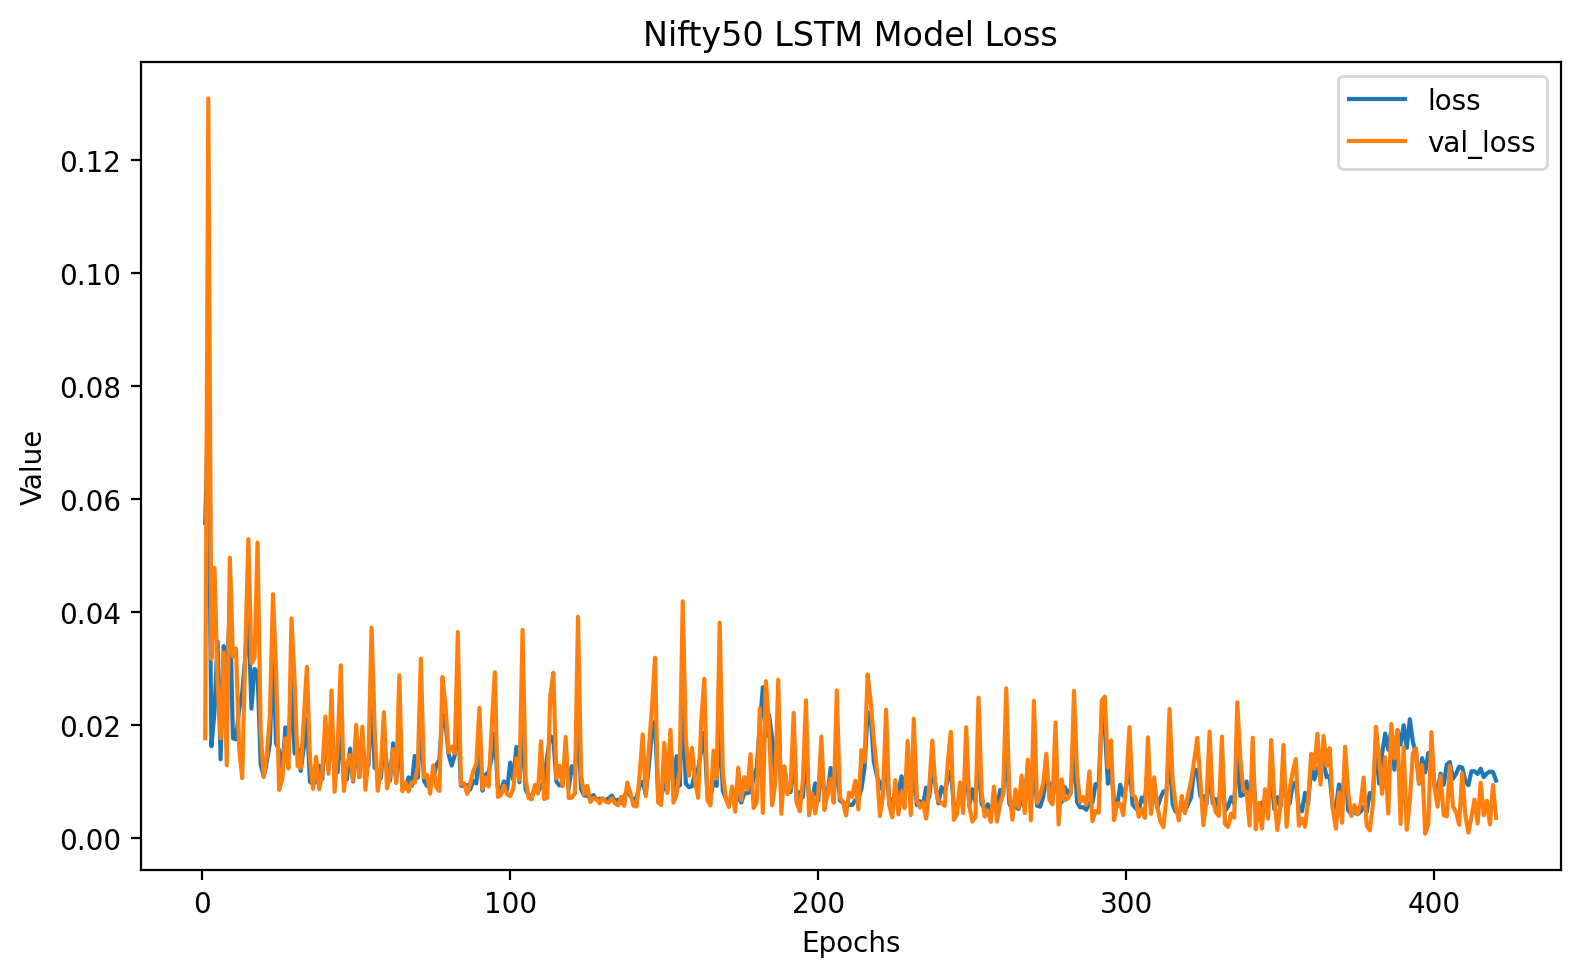

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history, plot_title='Training Performance', plot_legends=None):
    # Extracting metrics from the history object
    epochs = range(1, len(next(iter(history.values()))) + 1)
    plt.figure(figsize=(8, 5))

    # If no legends are provided, use keys from the history
    if not plot_legends:
        plot_legends = list(history.keys())

    # Plotting data for each metric in the history
    for key, legend in zip(history.keys(), plot_legends):
        plt.plot(epochs, history[key], label=legend)

    # Adding labels and title
    plt.title(plot_title)
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()

    # Disabling grid lines
    plt.grid(False)

    plt.tight_layout()

    # Setting background color to white
    plt.gca().set_facecolor('white')

    plt.show()

# Plotting LSTM model loss
plot_training_history(history.history, plot_title='Nifty50 LSTM Model Loss')

In [ ]:
# Loading best weights during training
model = models.load_model(f'LSTM_Nifty50_model.h5')

# Predicting
predictions = model.predict(X_test, verbose=False)
predictions = scaler.inverse_transform(predictions)



In [ ]:
df.head()

,close
Date,
2014-01-02 00:00:00+05:30,6221.149902
2014-01-03 00:00:00+05:30,6211.149902
2014-01-06 00:00:00+05:30,6191.450195
2014-01-07 00:00:00+05:30,6162.250000
2014-01-08 00:00:00+05:30,6174.600098


In [ ]:
# Showing predictions and data
index_1 = y_test.shape[0]
df_y_test = df[columns].iloc[-index_1:]
df_predictions = pd.DataFrame(predictions, index=df_y_test.index, columns=[f'pred_{col}' for col in columns])
df_test_pred = pd.concat([df_y_test, df_predictions], axis=1)

# Shwoing outputs
df_test_pred.tail()

,close,pred_close
Date,,
2024-06-25 00:00:00+05:30,23721.300781,23698.107422
2024-06-26 00:00:00+05:30,23868.800781,23848.927734
2024-06-27 00:00:00+05:30,24044.500000,24022.216797
2024-06-28 00:00:00+05:30,24010.599609,23998.205078
2024-07-01 00:00:00+05:30,24141.949219,24120.474609


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming df_predictions and df_y_test are already defined
# Error dataframe
df_error = pd.DataFrame(df_predictions.values - df_y_test.values, index=df.index[-index_1:], columns=[f'error_{col}' for col in columns])

# RMSE
rmse_per_column = (df_error**2).mean()**(1/2)


# MAE
mae_per_column = df_error.abs().mean()


# Convert error values to human-readable format
rmse_per_column_readable = rmse_per_column.copy()
mae_per_column_readable = mae_per_column.copy()

# Assuming the 'volume' column represents trading volume, you can add 'M' for million
# and format the price error values as currency (e.g., USD)
if 'volume' in columns:
    rmse_per_column_readable.loc['error_volume'] /= 1e6  # convert volume to million units
    mae_per_column_readable.loc['error_volume'] /= 1e6  # convert volume to million units

print('\nRMSE Per Column (Readable)')
print(rmse_per_column_readable)

print('\nMAE Per Column (Readable)')
print(mae_per_column_readable)






RMSE Per Column (Readable)
error_close    17.417727
dtype: float64

MAE Per Column (Readable)
error_close    13.400301
dtype: float64


In [ ]:
import numpy as np

# Error dataframe
#df_error = pd.DataFrame(df_predictions.values - df_y_test.values, index=denoised_df.index[-index_1:], columns=[f'error_{col}' for col in columns])
df_error = pd.DataFrame(df_predictions.values - df_y_test.values, index=df.index[-index_1:], columns=[f'error_{col}' for col in columns])

# RMSE
rmse_per_column = (df_error**2).mean()**(1/2)

# MAE
mae_per_column = df_error.abs().mean()

# MAPE
# MAPE with correction for zero values in df_y_test
mape_per_column = {}

for col in columns:
    mask = df_y_test[col] != 0
    if mask.sum() == 0:
        mape_per_column[f'error_{col}'] = np.nan
    else:
        mape_per_column[f'error_{col}'] = (df_error[f'error_{col}'][mask].abs() / df_y_test[col][mask]).mean() * 100

mape_per_column = pd.Series(mape_per_column)
# Convert error values to human-readable format
rmse_per_column_readable = rmse_per_column.copy()
mae_per_column_readable = mae_per_column.copy()
mape_per_column_readable = mape_per_column.copy()

# Assuming the 'volume' column represents trading volume, you can add 'M' for million
# and format the price error values as currency (e.g., USD)
if 'volume' in columns:
    rmse_per_column_readable.loc['error_volume'] /= 1e6  # convert volume to million units
    mae_per_column_readable.loc['error_volume'] /= 1e6  # convert volume to million units
    mape_per_column_readable.loc['error_volume'] = mape_per_column.loc['error_volume']

print('\nprint test pred shape')
print(df_predictions.shape)

print('\nRMSE Per Column (Readable)')
print(rmse_per_column_readable)

print('\nMAE Per Column (Readable)')
print(mae_per_column_readable)

print('\nMAPE Per Column (Readable)')
print(mape_per_column_readable)

df_error.head(10)


print test pred shape
(511, 1)

RMSE Per Column (Readable)
error_close    17.417727
dtype: float64

MAE Per Column (Readable)
error_close    13.400301
dtype: float64

MAPE Per Column (Readable)
error_close    0.070694
dtype: float64


,error_close
Date,
2022-06-03 00:00:00+05:30,31.511719
2022-06-06 00:00:00+05:30,25.400391
2022-06-07 00:00:00+05:30,37.400391
2022-06-08 00:00:00+05:30,21.616211
2022-06-09 00:00:00+05:30,2.431641
2022-06-10 00:00:00+05:30,49.274414
2022-06-13 00:00:00+05:30,54.782227
2022-06-14 00:00:00+05:30,1.591797
2022-06-15 00:00:00+05:30,8.955078


In [ ]:
def plot_single_residual_analysis(df, column):
    """
    Perform residual analysis for a single feature in a DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing actual and predicted columns.
        column (str): Name of the column to plot.
    """
    actual = df[column]
    predicted = df[f'pred_{column}']
    residuals = actual - predicted
    mean_residuals = np.mean(residuals)
    sd_residuals = np.std(residuals)
    rmse = np.sqrt(np.mean(residuals**2))
    index = df.index

    # Color for the plot
    color = 'blue'

    # Create a new figure with subplots
    fig = make_subplots(rows=2, cols=2, subplot_titles=("Histogram of Residuals", "QQ-Normal Plot",
                                                        "Residuals vs. Predicted Values", "Residuals vs Index"),
                        vertical_spacing=0.2, horizontal_spacing=0.2)  # Adjust spacing here

    # Histogram of residuals
    fig.add_trace(go.Histogram(x=residuals, nbinsx=30, name=f'{column.title()} Residuals', marker_color=color), row=1, col=1)
    # Add lines for mean and standard deviation
    fig.add_vline(x=mean_residuals, line=dict(color='black', width=2), row=1, col=1)
    fig.add_vline(x=mean_residuals + sd_residuals, line=dict(color='grey', width=2, dash='dash'), row=1, col=1)
    fig.add_vline(x=mean_residuals - sd_residuals, line=dict(color='grey', width=2, dash='dash'), row=1, col=1)
    fig.add_annotation(x=mean_residuals, y=5, text=f"Mean: {mean_residuals:.2f}", showarrow=True, row=1, col=1)
    fig.add_annotation(x=sd_residuals + mean_residuals, y=5, text=f"SD: {sd_residuals:.2f}", showarrow=False, row=1, col=1)

    # QQ-Normal of residuals
    qq = stats.probplot(residuals, dist="norm", plot=None)
    fig.add_trace(go.Scatter(x=qq[0][0], y=qq[1][1] + qq[1][0]*qq[0][0], mode='lines',  showlegend=False), row=1, col=2)
    fig.add_trace(go.Scatter(x=qq[0][0], y=qq[0][1], mode='markers', marker_color=color, name=f'{column.title()} QQ'), row=1, col=2)

    # Residuals vs. predicted values
    fig.add_trace(go.Scatter(x=predicted, y=residuals, mode='markers', marker_color=color, name=f'{column.title()} Resid Pred'), row=2, col=1)
    fig.add_hline(y=0, line=dict(color='red'), row=2, col=1)
    fig.add_hline(y=2 * rmse, line=dict(color='red', dash='dash'), row=2, col=1)
    fig.add_hline(y=-2 * rmse, line=dict(color='red', dash='dash'), row=2, col=1)

    # Residuals vs. index
    fig.add_trace(go.Scatter(x=index, y=residuals, mode='markers', marker_color=color, name=f'{column.title()} Resid Index'), row=2, col=2)
    fig.add_hline(y=0, line=dict(color='red'), row=2, col=2)
    fig.add_hline(y=2 * rmse, line=dict(color='red', dash='dash'), row=2, col=2)
    fig.add_hline(y=-2 * rmse, line=dict(color='red', dash='dash'), row=2, col=2)

    # Update layout
    fig.update_layout(height=800, width=1000, title_text=f"Residual Analysis - {column.title()}")
    fig.show()

# Loop through columns and plot individual residual analysis
for col in df_test_pred.columns:
    if col.startswith('pred_'):
        column = col.split('_')[1]
        plot_single_residual_analysis(df_test_pred, column)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def plot_predictions(y_values_df, predictions_df, title_add=''):
    """
    Plots actual values and predictions for each feature in separate subplots.

    Args:
        y_values_df (pd.DataFrame): DataFrame containing actual values.
        predictions_df (pd.DataFrame): DataFrame containing predicted values.
        title_add (str, optional): Additional title for the subplots.
    """
    # Number/color per features
    columns = [col for col in y_values_df.columns]
    num_features = len(columns)
    actual_colors = ['red', 'lime', 'violet', 'yellow', 'gold', 'pink']

    # Creating subplots
    fig = make_subplots(rows=num_features, cols=1, vertical_spacing=0.07, subplot_titles=[col.title() for col in columns])

    for i, col in enumerate(columns):
        # Actual values trace
        fig.add_trace(go.Scatter(x=y_values_df.index, y=y_values_df[col], mode='lines', name=col.title(),
                                 line=dict(color=actual_colors[i % len(actual_colors)])), row=i+1, col=1)

        # Predicted values trace
        pred_col = f'pred_{col}'
        if pred_col in predictions_df.columns:
            fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df[pred_col],
                                     mode='lines', name=f'Predicted {col.title()}', line=dict(color='blue')), row=i+1, col=1)

            # Calculate RMSE and MAE
            rmse = np.sqrt(mean_squared_error(y_values_df[col], predictions_df[pred_col]))
            mae = mean_absolute_error(y_values_df[col], predictions_df[pred_col])

            # Convert RMSE and MAE of 'volume' to million units
            if col == 'volume':
                rmse /= 1e6
                mae /= 1e6

            # Add RMSE and MAE as annotations
            fig.add_annotation(xref='x domain', yref='y domain', x=1, y=0.05, showarrow=False,
                               text=f'RMSE: {rmse:.2f}', row=i+1, col=1, font=dict(color='red'))

            fig.add_annotation(xref='x domain', yref='y domain', x=1, y=0.1, showarrow=False,
                               text=f'MAE: {mae:.2f}', row=i+1, col=1, font=dict(color='green'))

    fig.update_layout(height=350*num_features, width=1100, title_text="Actual & Predictions " + title_add)
    fig.show()

# Plotting prediction and data
plot_predictions(df_y_test, df_predictions, title_add=f'- Nifty50 nonstacked LSTM')


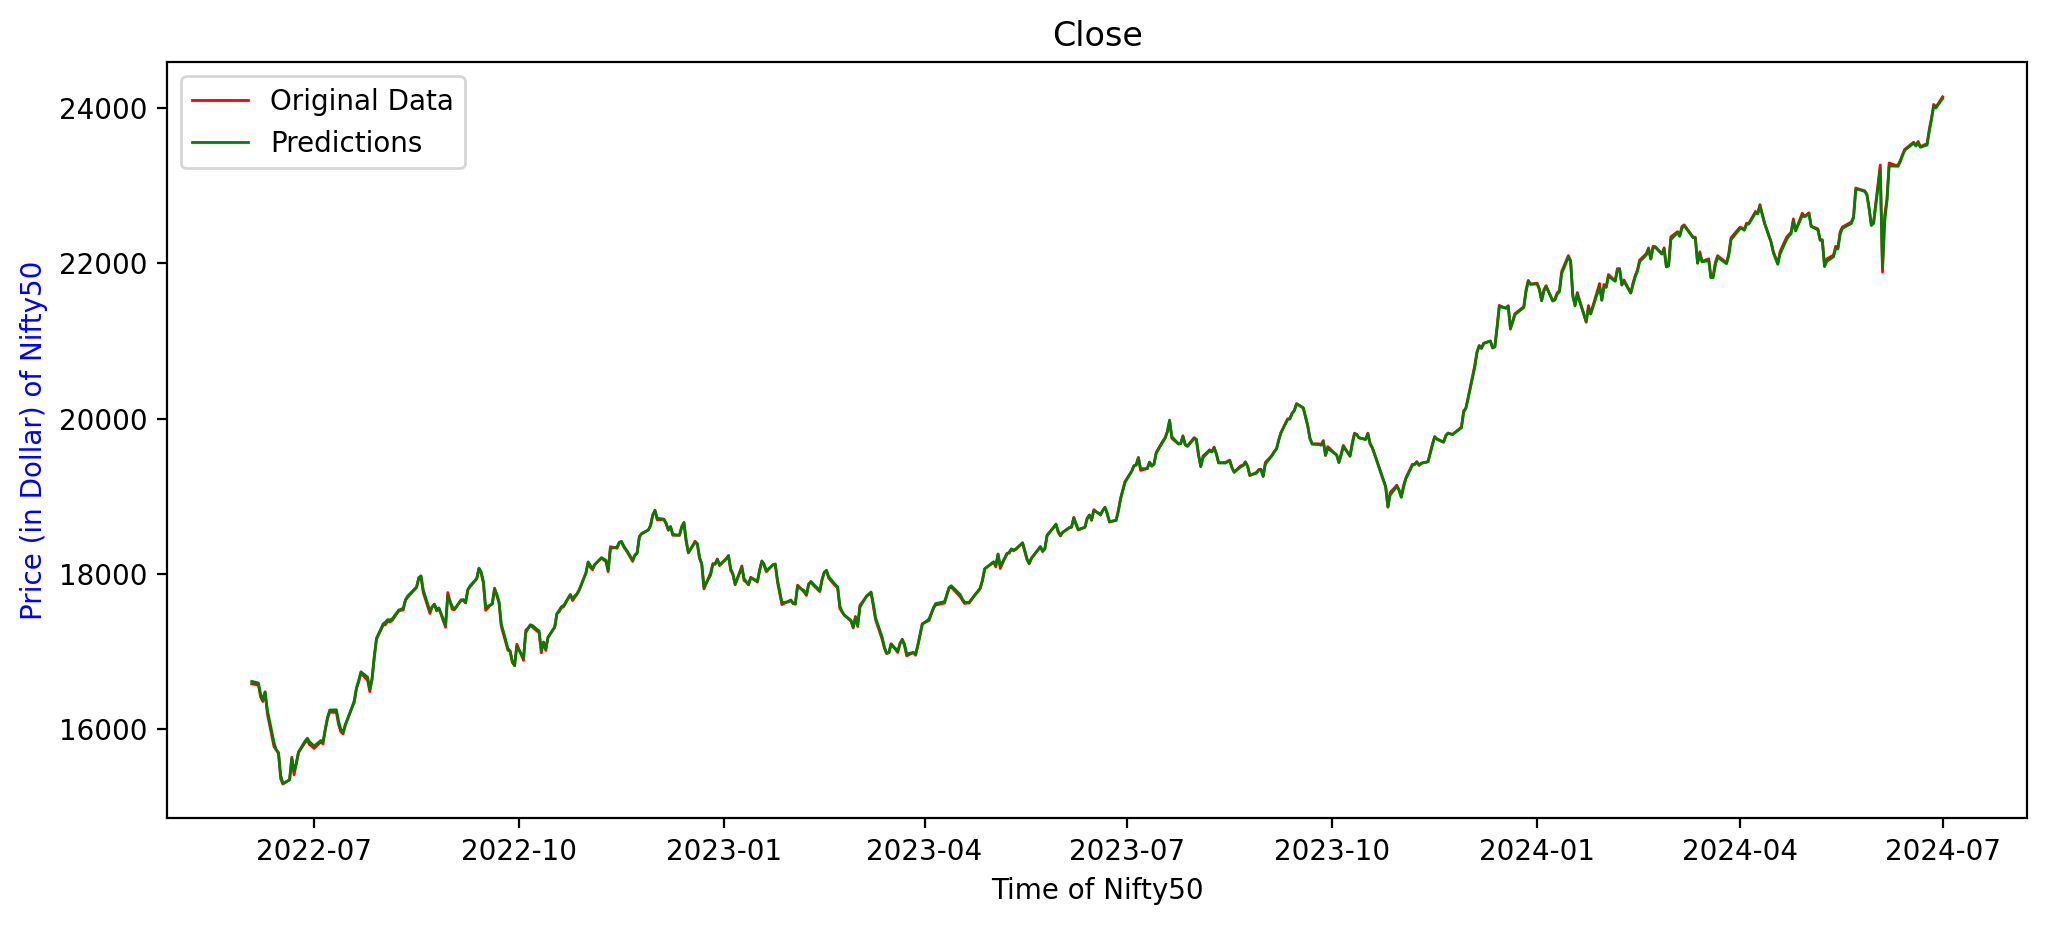

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions_vs_actual_data(actual_df, predictions_df, columns, actual_color='green', pred_color='red'):
    fig, axes = plt.subplots(len(columns), 1, figsize=(12, 4.5*len(columns)))
    # fig.suptitle(title, fontsize=16, y=0.95)  # Set the title and adjust the vertical position

    if len(columns) == 1:
        axes = [axes]

    for i, col in enumerate(columns):
        ax = axes[i]

        # Plot actual data
        ax.plot(actual_df.index, actual_df[col], color=actual_color, label='Original Data', linewidth=1.0)

        # Plot predictions
        ax.plot(predictions_df.index, predictions_df[f'pred_{col}'], color=pred_color, label='Predictions', linewidth=1.0)

        # Adjust y-axis label
        y_label = "Price (in Dollar) of Nifty50" if "volume" not in col.lower() else "Volume"
        ax.set_ylabel(y_label, color='blue')  # Adjust the color of the y-axis label

        ax.set_title(col.title())
        ax.set_xlabel("Time of Nifty50")
        ax.legend()

    plt.subplots_adjust(top=0.95, hspace=0.5)  # Adjust the horizontal spacing
    plt.show()

# Assuming df_y_test, df_predictions, and columns are defined
plot_predictions_vs_actual_data(df_y_test, df_predictions, columns, actual_color='red', pred_color='green')

In [ ]:
def forecast_next_20_days(model, recent_data, scaler, num_days=20):
    # Prepare a list to store the predictions
    forecasted_values = []

    # Loop for the number of days we want to forecast
    for _ in range(num_days):
        # Reshape the recent data for prediction
        input_data = recent_data[-mapping_steps:].reshape(1, mapping_steps, len(columns))

        # Predict the next value
        next_value = model.predict(input_data, verbose=False)

        # Store the predicted value
        forecasted_values.append(next_value[0])

        # Append the predicted value to the recent data
        recent_data = np.append(recent_data, next_value, axis=0)

    # Inverse transform the forecasted values to the original scale
    forecasted_values = np.array(forecasted_values).reshape(-1, len(columns))
    forecasted_values = scaler.inverse_transform(forecasted_values)

    return forecasted_values

# Use the last part of the training data to initialize the recent_data
recent_data = normalized_data[-mapping_steps:]

# Forecast the next 20 days
forecasted_values = forecast_next_20_days(model, recent_data, scaler)

# Create a DataFrame to hold the forecasted values
forecast_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=20, freq='B')
df_forecast = pd.DataFrame(forecasted_values, index=forecast_dates, columns=[f'forecast_{col}' for col in columns])

print("Forecasted values for the next 20 days of Nifty50:")
print(df_forecast)




Forecasted values for the next 20 days of Nifty50:
                           forecast_close
2024-07-02 00:00:00+05:30    24120.437500
2024-07-03 00:00:00+05:30    24109.216797
2024-07-04 00:00:00+05:30    24095.734375
2024-07-05 00:00:00+05:30    24082.300781
2024-07-08 00:00:00+05:30    24068.142578
2024-07-09 00:00:00+05:30    24052.753906
2024-07-10 00:00:00+05:30    24036.029297
2024-07-11 00:00:00+05:30    24018.103516
2024-07-12 00:00:00+05:30    23999.193359
2024-07-15 00:00:00+05:30    23979.529297
2024-07-16 00:00:00+05:30    23959.312500
2024-07-17 00:00:00+05:30    23938.710938
2024-07-18 00:00:00+05:30    23917.849609
2024-07-19 00:00:00+05:30    23896.822266
2024-07-22 00:00:00+05:30    23875.703125
2024-07-23 00:00:00+05:30    23854.533203
2024-07-24 00:00:00+05:30    23833.339844
2024-07-25 00:00:00+05:30    23812.140625
2024-07-26 00:00:00+05:30    23790.941406
2024-07-29 00:00:00+05:30    23769.755859


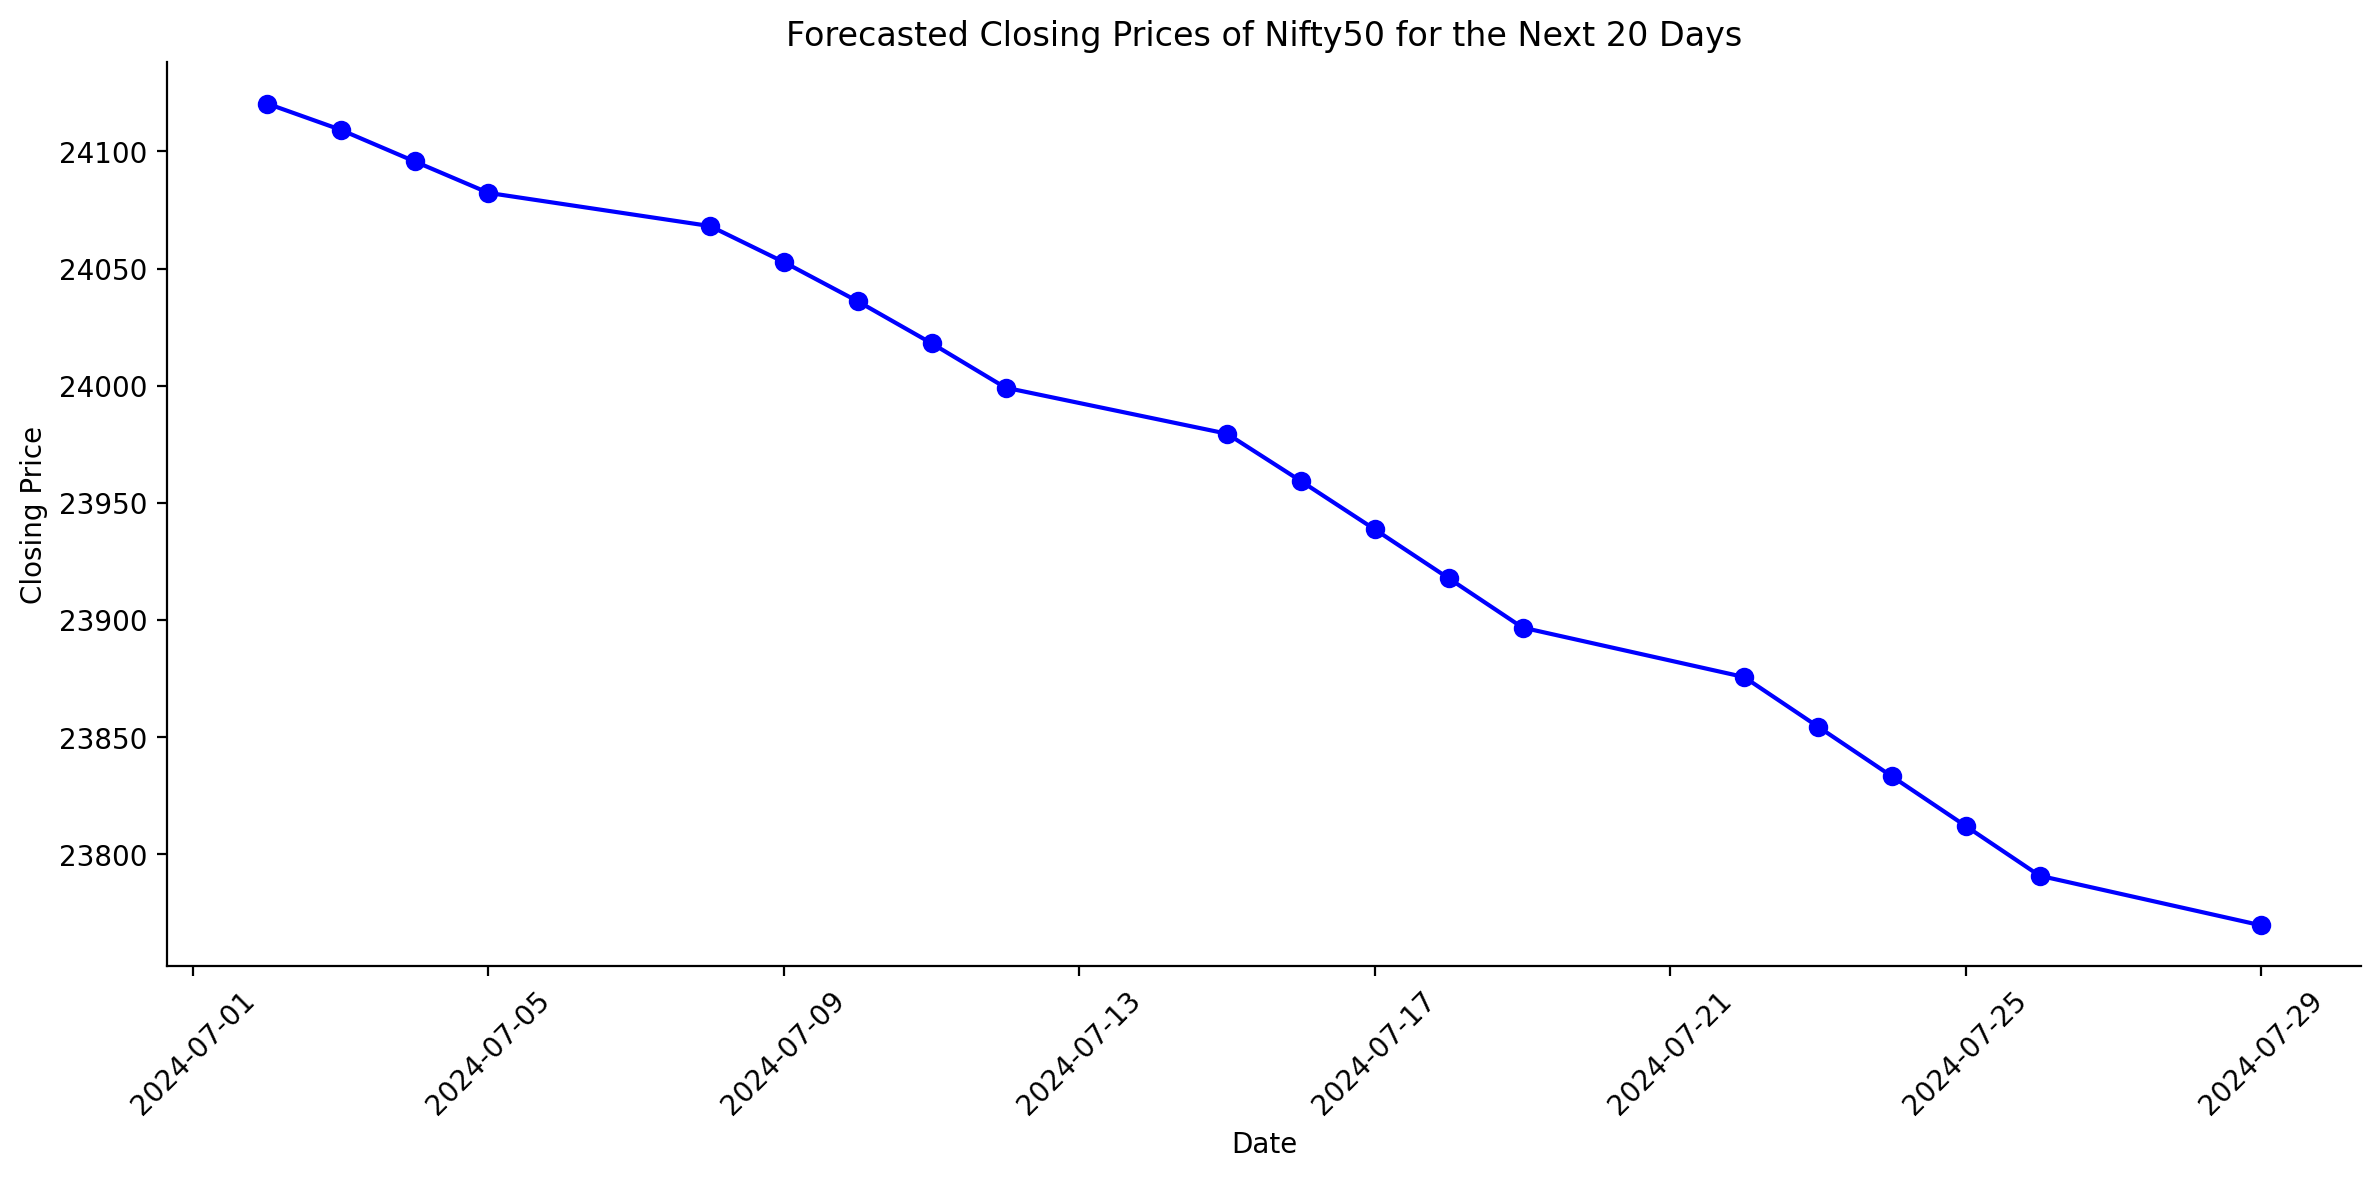

In [ ]:
# Plotting the forecasted values using Matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_forecast.index, df_forecast['forecast_close'], marker='o', linestyle='-', color='b')
plt.title('Forecasted Closing Prices of Nifty50 for the Next 20 Days')
plt.xlabel('Date')
plt.ylabel('Closing Price')

# Remove the top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a grid and rotate x-axis labels for better readability
#plt.grid(True, linestyle='--', alpha=0.7)  # Add a light grid with dashed lines
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

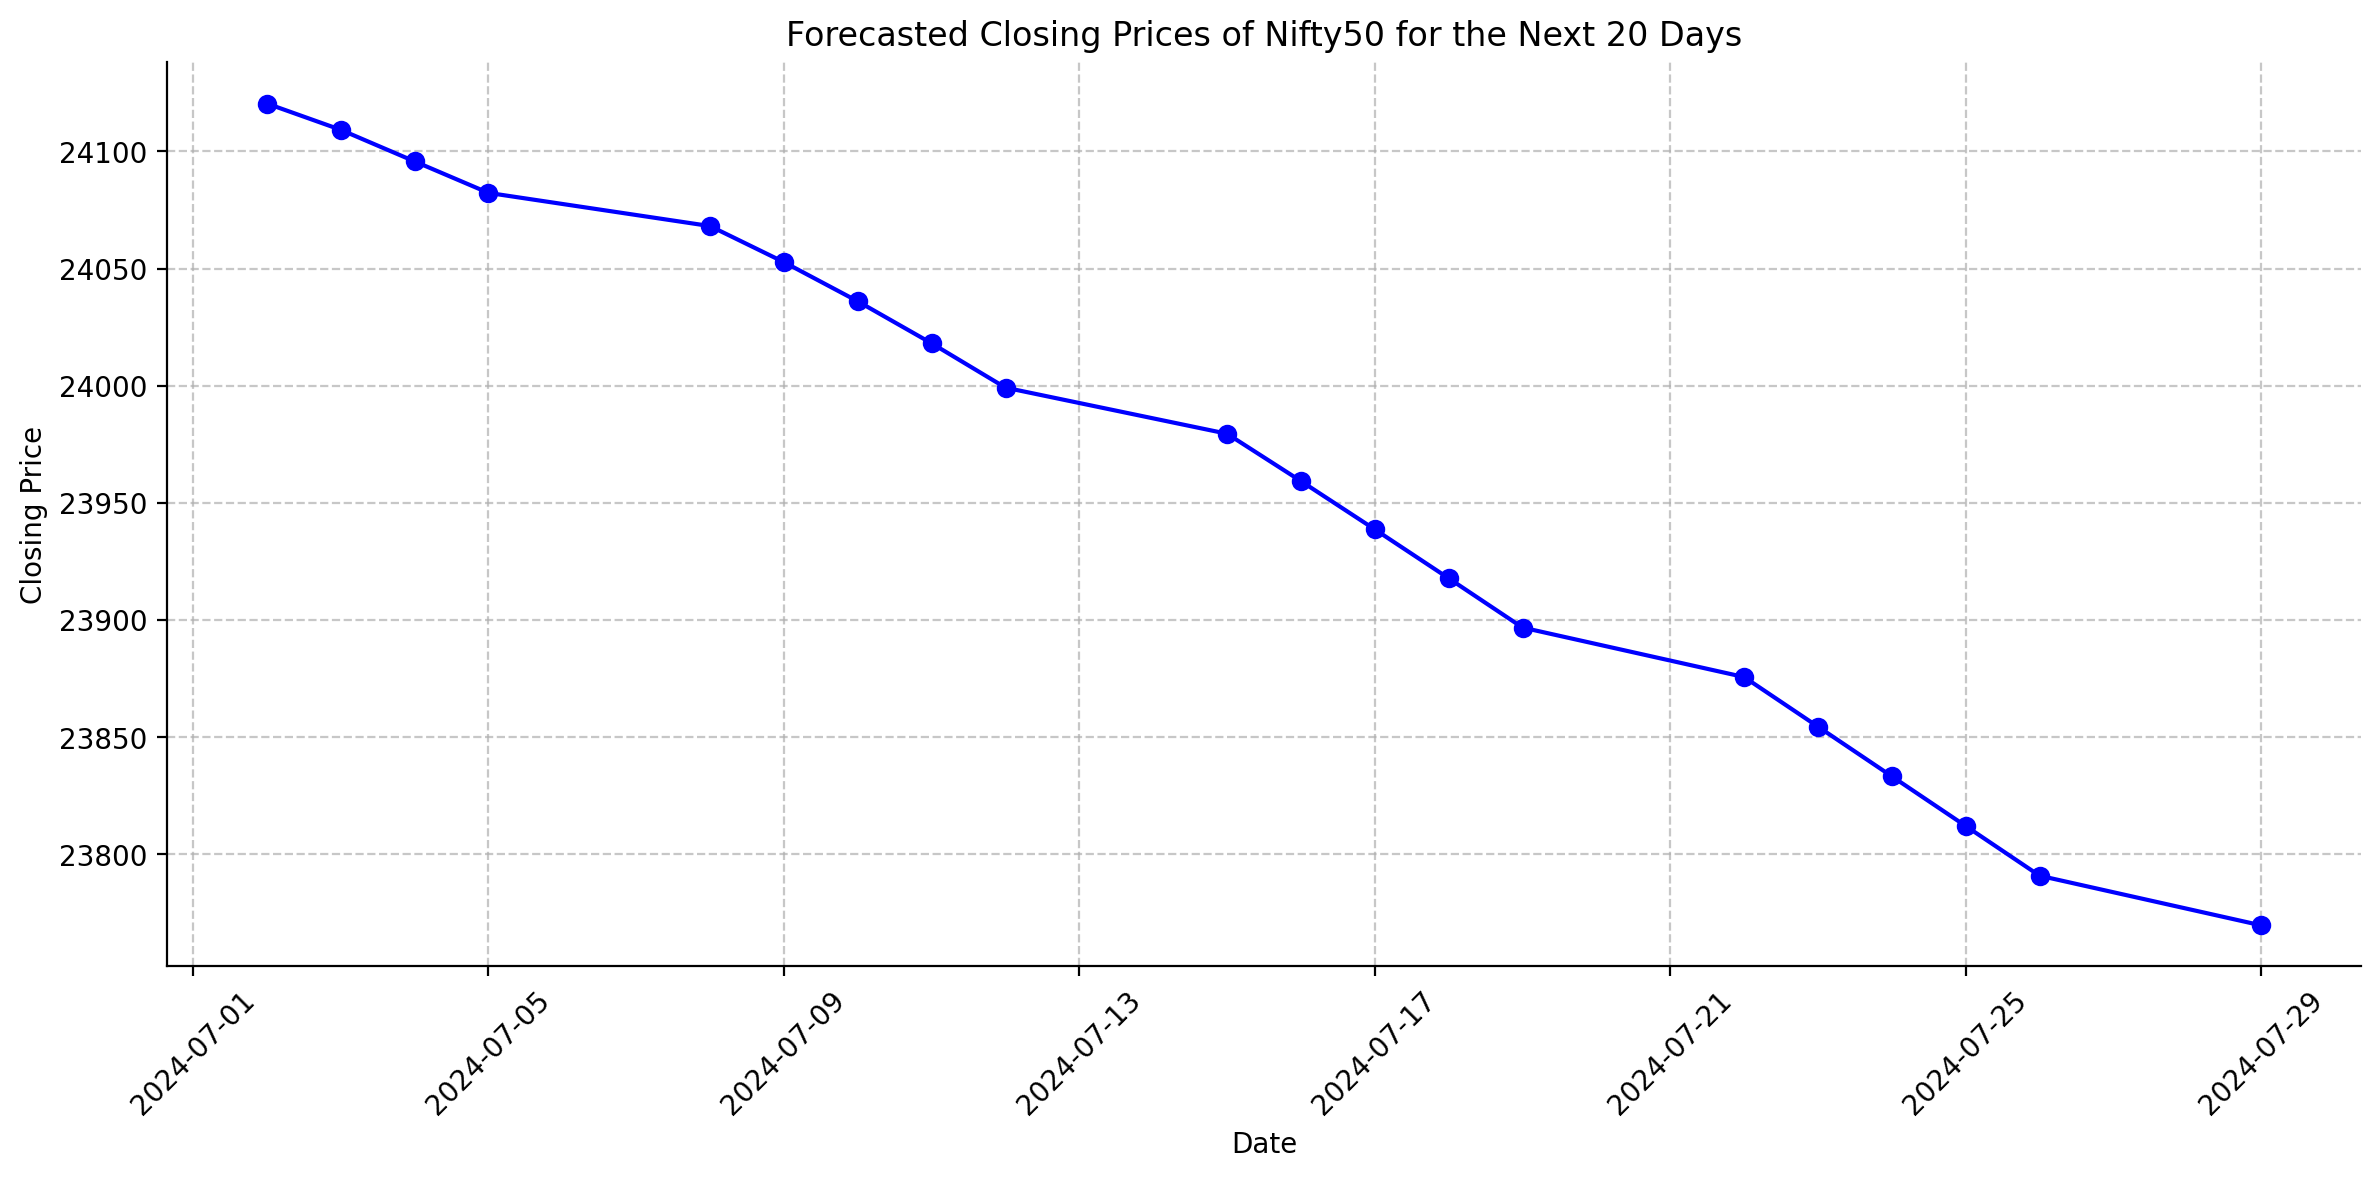

In [ ]:
# Plotting the forecasted values using Matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_forecast.index, df_forecast['forecast_close'], marker='o', linestyle='-', color='b')
plt.title('Forecasted Closing Prices of Nifty50 for the Next 20 Days')
plt.xlabel('Date')
plt.ylabel('Closing Price')

# Remove the top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a grid and rotate x-axis labels for better readability
plt.grid(True, linestyle='--', alpha=0.7)  # Add a light grid with dashed lines
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()